In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import mesh_tensorflow as mtf

import flowpm
import flowpm.mesh_ops as mpm
import flowpm.mtfpm as mtfpm
import flowpm.mesh_utils as mesh_utils
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
from flowpm import linear_field, lpt_init, nbody, cic_paint
from flowpm.utils import r2c3d, c2r3d

sys.path.append('../utils/')
import tools
import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt


In [3]:
from recurrent_inference import rim, ConvRIM3D
from convolutional_recurrent import ConvLSTM3DCell
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers.convolutional_recurrent import ConvLSTM2DCell



In [4]:
bb = 11
nc = 8 
cc = 2
tt = 5
filters = 7


inp = np.random.normal(size=bb*tt*nc**2*cc).reshape(bb, tt, nc, nc, cc).astype(float32)
states = np.zeros(shape = (2, bb, nc, nc, filters)).astype(float32)

layer2d = ConvLSTM2D(filters=filters, kernel_size = 3, padding='SAME', return_state=True, return_sequences=True)
out = layer2d(inp)
print(len(out))
out[0].shape, out[1].shape, out[2].shape

3


(TensorShape([11, 5, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]))

In [5]:
wts = layer2d.cell.get_weights()
for i in wts:
    print(i.shape)

(3, 3, 2, 28)
(3, 3, 7, 28)
(28,)


In [6]:
inp[:, 0].shape

(11, 8, 8, 2)

In [135]:
cell2d = ConvLSTM2DCell(filters=filters, kernel_size = 3, padding='SAME')
out = cell2d(inp[:, 0],  states)
# out = cell2d(inp,  [states]*tt)
out[0].shape, len(out[1]), out[1][0].shape, out[1][1].shape

(TensorShape([11, 8, 8, 7]),
 2,
 TensorShape([11, 8, 8, 7]),
 TensorShape([11, 8, 8, 7]))

In [146]:
inp3d = np.random.normal(size=bb*tt*nc**3*cc).reshape(bb, tt, nc, nc, nc, cc).astype(float32)
states3d = np.zeros(shape = (2, bb, nc, nc, nc, filters)).astype(float32)
cell3d = ConvLSTM3DCell(filters=filters, kernel_size = 3, padding='SAME')
cell3d(inp3d[:, 0], states3d);

# rim

In [79]:
bb = 11
nc = 8 
cc = 1
tt = 5
filters = 5

inp3d = np.random.normal(size=bb*tt*nc**3*cc).reshape(bb, tt, nc, nc, nc, cc).astype(float32)
states3d = np.zeros(shape = (2, bb, nc, nc, nc, filters)).astype(float32)
cell3d = ConvLSTM3DCell(filters=filters, kernel_size = 3, padding='SAME')
cell3d(inp3d[:, 0], states3d);


In [80]:

inprim = np.random.normal(size=bb*1*nc**3*cc).reshape(bb, nc, nc, nc, cc).astype(float32)
statesrim = np.zeros(shape = (2, bb,  nc, nc, nc, filters)).astype(float32)
output_layer = tf.keras.layers.Conv3D(filters=1, kernel_size=3, padding='SAME')


# rim(cell3d.call, tf.constant(inprim), tf.constant(statesrim), 1)
cvrim = ConvRIM3D(cell3d, output_layer, None, 1)

In [9]:
# cvrim.get_initial_state(inprim);

In [10]:

# def model(x):
#     return tf.reduce_sum(tf.square(x-tf.constant(2, dtype=tf.float32)))

# @tf.function
# def val_and_grad(x):
#     with tf.GradientTape() as tape:
#         tape.watch(x)
#         loss = model(x)
#     grad = tape.gradient(loss, x)
#     return loss, grad

# def func(x):
#     return [vv.numpy().astype(np.float64)  for vv in val_and_grad(tf.constant(x, dtype=tf.float32))]

# resdd= sopt.minimize(fun=func, x0=np.ones(5),
#                                       jac=True, method='L-BFGS-B')

# print("info:\n",resdd)

# PM

In [11]:
bs, nc = 100, 16
nsteps = 3
a0, a, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, a, nsteps, endpoint=True)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                                                           
kvec = tools.fftk((nc, nc, nc), boxsize=nc, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)


<ipython-input-11-0d1dad7ca900>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)


In [12]:
dpath = '../data/rim-data/L%04d_N%03d_T%02d/'%(bs, nc, nsteps)

alldata = np.array([np.load(dpath + '%04d.npy'%i) for i in range(100)]).astype(float32)


#Simple recon with ADAM

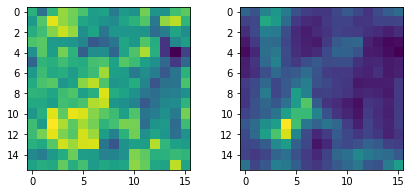

In [13]:
ic, fin = alldata[0]
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(ic.sum(axis=0))
ax[1].imshow(fin.sum(axis=0))
ic, fin = np.expand_dims(ic, 0), np.expand_dims(fin, 0)


In [14]:
tf.keras.backend.clear_session()


In [15]:
@tf.function
def pm(linear):
    state = lpt_init(linear, a0=0.1, order=1)
    final_state = nbody(state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return tfinal_field


@tf.function
def recon_prototype(linear, data, Rsm, anneal=True):
    """                                                                                                                                                   
    """
    print(linear)
#     linear = tf.reshape(linear, data.shape)
    final_field = pm(linear)

    residual = final_field - data #.astype(np.float32)
    base = residual

    if anneal :
        print("\nAdd annealing section to graph\n")
        Rsmsq = tf.multiply(Rsm*bs/nc, Rsm*bs/nc)
        smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
        basek = r2c3d(base, norm=nc**3)
        basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
        base = c2r3d(basek, norm=nc**3)

    chisq = tf.multiply(base, base)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**3, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def val_and_grad(x, y, Rsm):
    print("val and grad : ", x.shape)
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, x)
    return loss, grad

@tf.function
def grad(x, y, Rsm):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm)
    grad = tape.gradient(loss, [x])
    return grad


# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)



In [16]:
# recon_prototype(linear, tf.constant(fin), tf.constant(0., dtype=tf.float32))


In [17]:
RRs = [0]
optimizer = 'adam'
niter = 100


#Loop it Reconstruction                                                                                                                                   
##Reconstruction                                                                                                                                          
x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                         initial_value=x0, trainable=True)

for iR, RR in enumerate(RRs):

    for i in range(niter):
        grads = grad(linear, tf.constant(fin, dtype=tf.float32), tf.constant(RR, dtype=tf.float32))
#         recon_prototype(linear, tf.constant(fin), tf.constant(0., dtype=tf.float32))
        opt.apply_gradients(zip(grads, [linear]))
    minic = linear.numpy().reshape(fin.shape)
    
    x0 = minic
    
#     #                                                                                                                                                     
#     print('\nminimized\n')
#     minfin = pm(tf.constant(minic, dtype=tf.float32)).numpy()
#     dg.saveimfig("-R%d"%RR, [minic, minfin], [ic, fin], fpath+'')
#     dg.save2ptfig("-R%d"%RR, [minic, minfin], [ic, fin], fpath+'', bs)
#     ###                                                                                                                                                   
#     x0 = minic
# exit(0)




<tf.Variable 'linmesh:0' shape=(1, 16, 16, 16) dtype=float32>

Add annealing section to graph



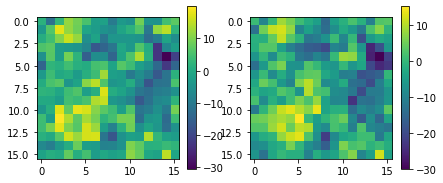

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
im = ax[0].imshow(ic[0].sum(axis=0))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(minic[0].sum(axis=0))
plt.colorbar(im, ax=ax[1])

#  RIM


In [5]:
# from recurrent_inference import ConvRIM3D
# from convolutional_recurrent import ConvLSTM3DCell


# @tf.function
# def likelihood_fn(inputs, predictions):
#   """ Evaluates the data likelihood function through Fast PM
#   """
#   final_field = pm(predictions[..., 0])
#   likelihood = tf.reduce_mean((final_field - inputs[...,0])**2/sigma**2, 
#                               axis=[1, 2, 3])
#   return likelihood

# @tf.function
# def gradient_fn(inputs, predictions):
#     """ Evaluates the data likelihood function through Fast PM
#     """
#     with tf.GradientTape() as tape:
#         tape.watch(x)
#         loss = likelihood_fn(x, y, Rsm)
#     grad = tape.gradient(loss, [x])
#     return grad
  

In [7]:
from tensorflow.python.keras.layers import LSTMCell, LSTM


In [8]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 1000
size_test = 500

In [9]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma, (2,))

def generate_A():
    D = np.diag(np.random.choice([-1,1], (2,)) * np.random.uniform(0.25, 1, (2,)))
    theta = np.random.uniform(0,2*np.pi)
    P = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.linalg.inv(P).dot(D).dot(P)

def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)

In [10]:
A_train = np.array([generate_A() for i in range(size_train)]).astype(float32)
sigma_train = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_train)]).astype(float32)

X_train = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_train)]).astype(float32)
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)]).astype(float32)
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)]).astype(float32)
X0_train = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_train]).astype(float32)

In [11]:
A_test = np.array([generate_A() for i in range(size_test)]).astype(float32)
sigma_test = np.array([np.abs(np.random.uniform(0, 1)) for i in range(size_test)]).astype(float32)

X_test = np.array([np.random.uniform(-5, 5, (2,)) for i in range(size_test)]).astype(float32)
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)]).astype(float32)
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)]).astype(float32)
X0_test = np.array([x_min + np.random.uniform(-10,10,(2,)) for x_min in X_min_test]).astype(float32)

# GD

In [152]:
lr = 0.1

list_xt_gd = []
for (x0, y, A) in zip(X0_test, Y_test, A_test):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

In [34]:

extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])
XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)
Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])


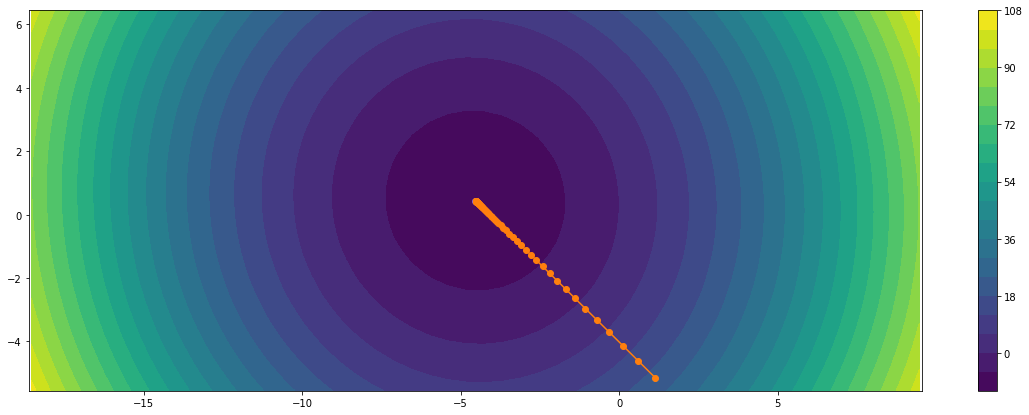

In [35]:
i_example = 37

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

# Code RIM

In [151]:
del rim

In [10]:
from recurrent_inference import rim


In [23]:
output_size = 2
cell = LSTMCell(output_size)
cell.build([None, 4])

In [24]:
bb = 10
niter = 10

xx, yy = X_train[:bb].astype(float32), Y_train[:bb].astype(float32)
A = A_train[0]
idx = np.random.randint(0, X_train.shape[0], 100)
xx, yy = X_train[idx].astype(float32), Y_train[idx].astype(float32)
A = A_train[0]

# states = [np.zeros(shape=(1, 1, output_size)).astype(float32), 
#           np.zeros(shape=(1, 1, output_size)).astype(float32)]
states = tf.constant(np.zeros(shape=(2, idx.size,  output_size)).astype(float32))
states = [tf.Variable(states[0]), tf.Variable(states[1])]
out = cell(tf.constant(tf.concat([xx, xx*2], axis=-1)), states)

In [273]:
# idx = np.random.randint(0, X_train.shape[0], 100)
# xx, yy, AA = X_train[idx], Y_train[idx], A_train[idx]


# def test(x, A):
#     y = [x[i].dot(A[i]) for i in range(x.shape[0])]
#     return np.array(y)

# def test2(x, A):
#     y = [tf.matmul(x[i], A[i]) for i in range(x.shape[0])]
#     return y


# a = test2(tf.constant(xx), tf.constant(AA)).numpy()
# b = test(xx, AA)
# b.shape

In [274]:
niter = 5

In [209]:
A.shape

(2, 2)

In [220]:
@tf.function
def tf_loss2(x, y, A):
    n = tf.constant(x.shape[0])
    i = 0
    term3 = tf.TensorArray(tf.float32, size=n)
    while tf.less(i, n):
#         term2.append(tf.matmul(y[i], tf.matmul(A[i], tf.transpose(x[i]))))
        term3 = term3.write(i, x[i]*y[i])
        i = i+1
    return term3.stack()

idx = np.random.randint(0, X_train.shape[0], 100)
xx, yy, A = X_train[idx].astype(float32), Y_train[idx].astype(float32), A_train[idx].astype(float32)

tf_loss2(tf.constant(xx), tf.constant(yy), tf.constant(A))


<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[-4.28914316e-02,  5.80406809e+00],
       [-9.47564030e+00, -3.66294360e+00],
       [-1.96714714e-01,  1.44845176e+00],
       [ 9.87903923e-02, -6.88998997e-01],
       [ 1.53583300e+00,  3.19356173e-02],
       [-1.45412169e+01,  3.01169729e+00],
       [ 2.60905791e-02,  1.66876926e+01],
       [ 5.12896442e+00,  5.11653280e+00],
       [ 1.43319094e+00,  1.64518565e-01],
       [ 1.02510653e+01,  9.63774979e-01],
       [-5.20637369e+00,  3.00964499e+00],
       [ 8.84546280e+00,  6.02511024e+00],
       [-5.43068790e+00,  3.39336097e-01],
       [ 5.40121698e+00,  8.83013725e+00],
       [ 1.68545976e-01,  1.58045425e+01],
       [-6.74639195e-02, -3.29630584e-01],
       [-9.33938622e-01, -6.92530727e+00],
       [ 1.83631554e+01,  3.71404624e+00],
       [ 5.06874943e+00,  1.96495605e+00],
       [ 1.04149971e+01,  2.83127499e+00],
       [-5.29631519e+00,  3.05013925e-01],
       [-6.84044540e-01, -6.03312588e+00],
    

In [25]:

@tf.function
def tf_fwdmodel(x, A):
    return tf.matmul(x, A)

@tf.function
def tf_loss(x, y, A):
    term1 = 0.5 * tf.matmul(x, tf.matmul(tf.transpose(A), tf.matmul(A, tf.transpose(x)))) 
    term2 = - tf.matmul(y, tf.matmul(A, tf.transpose(x)))
    return term2 + term2

#     return tf.reduce_sum(y - tf.einsum('ij,ijl'))
@tf.function
def tf_loss2(x, y, A):
    n = tf.constant(x.shape[0])
    i = 0
    term2 = 0
    while tf.less(i, n):
        term2 = term2 - tf.matmul(y, tf.matmul(A, tf.transpose(x)))
        i = i+1
    return term2
#     return tf.reduce_sum(y - tf.einsum('ij,ijl'))

@tf.function
def grad(x, y, A):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = tf_loss(x, y, A)
    grad = tape.gradient(loss, x)
    return grad



@tf.function
def augmented_step_full(x, states, y, A):
    print('graph')
    gradient = grad(x, y, A)
    inp = tf.concat([y, gradient], axis=-1)
    return cell(inp, states)                        

@tf.function
def augmented_step(x, states):
    gradient = grad(x, yy, A)
    xconcat = tf.concat([x, gradient], axis=-1)
    return cell(xconcat, states)                        

# @tf.function
# def tf_fwdrim(x, y, A, initstates=None):
    
#     if initstates is None: 
#         initstates = [states[0]*0, states[1]*0]
#     step = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(y), 
#                                               tf.constant(A))
#     return step(tf.constant(y), initstates)
#     out = rim(step, tf.constant(y), initstates, 10)
#     return out


# @tf.function
def tf_fwdrim(x, y, A, initstates=None):
    
    if initstates is None: 
        initstates = [tf.constant(yy*0), tf.constant(yy*0)]
        
    step = lambda x, states: augmented_step_full(x, states, 
                                              tf.constant(yy*float32(np.random.normal(0, 1, 1))), 
                                              tf.constant(A*float32(np.random.normal(0, 1, 1))))
#     def step(x, states):
#         print('graph')
#         gradient = grad(x, tf.constant(y), tf.constant(A))
#         inp = tf.concat([y, gradient], axis=-1)
#         return cell(inp, states)                        
#     return step(tf.constant(y), initstates)
    out = rim(step, tf.constant(y), initstates)
#     out = rim(augmented_step, tf.constant(y), initstates)
    return out


@tf.function
def tf_fwdrim_loop(x, y, A, initstates=None):
    
    if initstates is None: 
        initstates = [y*0., y*0.]
        
    step = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(yy*(np.random.normal(0, 1, 1))), 
#                                               tf.constant(A*(np.random.normal(0, 1, 1))))
                                              y, A)

    outputs_ta = tf.TensorArray(size=niter, dtype=tf.float32)
    states_ta = tf.TensorArray(size=niter, dtype=tf.float32)

    def body(i, output_ta, states, state_ta):    
        new_output, new_state = step(y, states)
        output_ta = output_ta.write(i, new_output)
        state_ta = state_ta.write(i, new_state)
        return i +1 , output_ta, new_state, state_ta
    
    def cond(i, outputs_ta, states, state_ta):
        return i < niter

    final_output = tf.while_loop(
        cond,
        body,
        loop_vars=[
            0, outputs_ta, initstates, states_ta
        ],
        )
    
    return final_output[1].stack(), final_output[3].stack()


@tf.function
def tf_fwdrim_loop2(x, y, A, initstates=None):
    
    if initstates is None: 
        initstates = [y*0., y*0.]
        
    outputs_ta = tf.TensorArray(size=niter, dtype=tf.float32)
    states_ta = tf.TensorArray(size=niter, dtype=tf.float32)

    def body(i, output_ta, states, state_ta):  
        print(i)
        gradient = grad(x, y, A)
        xconcat = tf.concat([y, gradient], axis=-1)
        print(xconcat.shape, states[0].shape, states[1].shape)
        new_output, new_state = cell(xconcat, states)
        output_ta = output_ta.write(i, new_output)
        state_ta = state_ta.write(i, new_state)
        return i +1 , output_ta, new_state, state_ta
    
    i = tf.constant(0, dtype=tf.int32)
    curr_state = initstates
    while tf.less(i, tf.constant(niter)):
        print(i)
        i, outputs_ta, curr_state, states_ta =  body(i, outputs_ta, curr_state, states_ta)
    
    return outputs_ta.stack(), states_ta.stack()


In [26]:
# tf_fwdrim(tf.constant(X_train[idx], Y_train[idx], A_train[idx]))
out = tf_fwdrim_loop2(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[0]))

# for i in range(100):
#     out = tf_fwdrim_loop(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[0]))


Tensor("while/Placeholder_4:0", shape=(), dtype=int32)
Tensor("while/Placeholder_4:0", shape=(), dtype=int32)
(100, 4) (100, 2) (100, 2)


In [29]:
out[0];

In [278]:
# def tf_fwdrim2(x, y, A, initstates=None):
    
#     if initstates is None: 
#         initstates = [tf.constant(yy*0), tf.constant(yy*0)]
        
#     step = lambda x, states: augmented_step_full(x, states, 
#                                               tf.constant(y), 
#                                               tf.constant(A))
#     time = constant_op.constant(0, dtype='int32', name='time')

#     while_loop_kwargs = {
#       'cond': lambda time, *_: time < niter,
#       'maximum_iterations': niter,
#       'parallel_iterations': 32,
#       'swap_memory': True,
#     }

#     def _step(time, output_ta_t, *states):
#         """RNN step function.                                                                                                                                     
#         Arguments:                                                                                                                                                
#             time: Current timestep value.                                                                                                                         
#             current_solution: current solution                                                                                                                    
#             output_ta_t: TensorArray.                                                                                                                             
#             *states: List of states.                                                                                                                              
#         Returns:                                                                                                                                                  
#             Tuple: `(time + 1, output_ta_t) + tuple(new_states)`                                                                                                  
#         """
#         # The input to the RIM is the current solution,                                                                                                           
#         output, new_states = step(inputs,
#                                            tuple(states) + tuple(constants))
#         print("output : ", output)
#         flat_state = nest.flatten(states)
#         flat_new_state = nest.flatten(new_states)
#         for state, new_state in zip(flat_state, flat_new_state):
#           if isinstance(new_state, ops.Tensor):
#             new_state.set_shape(state.shape)

#         flat_output = nest.flatten(output)
#         print("flat_output : ", flat_output)
#         output_ta_t = tuple(
#             ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))
#         new_states = nest.pack_sequence_as(initial_states, flat_new_state)
#         return (time + 1, output_ta_t) + tuple(new_states)

#     final_outputs = control_flow_ops.while_loop(
#       body=_step,
#       loop_vars=(time, output_ta) + states,
#       **while_loop_kwargs)


#     return step(tf.constant(y), initstates)
#     out = rim(step, tf.constant(y), initstates, 5)
#     return out

In [279]:
for i in range(20):
    augmented_step(tf.constant(yy), [tf.constant(yy)*0, tf.constant(yy)*0])    

In [280]:
for i in range(30):
    rim(augmented_step, tf.constant(yy), [tf.constant(yy)*np.random.randint(1), 
                                          tf.constant(yy)**np.random.randint(1)]);



output :  Tensor("while/StatefulPartitionedCall:0", shape=(100, 2), dtype=float32)
flat_output :  [<tf.Tensor 'while/StatefulPartitionedCall:0' shape=(100, 2) dtype=float32>]
Tensor("TensorArrayV2Stack/TensorListStack:0", shape=(10, 100, 2), dtype=float32)


In [281]:
# for i in range(10):
#     tf_fwdrim(tf.constant(X_train[idx]), tf.constant(Y_train[idx]), tf.constant(A_train[0]))

In [282]:
# %%timeit

for i in range(100):
    out = rim(augmented_step, tf.constant(yy), states)


output :  Tensor("while/StatefulPartitionedCall:0", shape=(100, 2), dtype=float32)
flat_output :  [<tf.Tensor 'while/StatefulPartitionedCall:0' shape=(100, 2) dtype=float32>]
Tensor("TensorArrayV2Stack/TensorListStack:0", shape=(10, 100, 2), dtype=float32)


In [244]:
%%timeit 

for i in range(100):
    lstep = lambda x, states: augmented_step_full(x, states, 
                                              tf.constant(yy*float32(np.random.normal(0, 1, 1))), 
                                              tf.constant(A*float32(np.random.normal(0, 1, 1))))
    out = rim(lstep, tf.constant(yy), states, 5)


1.47 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [151]:
class myRIM(tf.keras.Model):

    def __init__(self, cell, niter):
#     def __init__(self, output_size, input_shape, niter):
        super(myRIM, self).__init__()
        self.cell = cell
#         self.cell = LSTMCell(output_size)
#         self.cell.build(input_shape)
        self.niter = niter

            
    def call(self, x_init, y, grad_fn, grad_args, initstates = None, return_steps=False):
        
        outputs_ta = tf.TensorArray(size=self.niter, dtype=tf.float32)
        states_ta = tf.TensorArray(size=self.niter, dtype=tf.float32)
        
        if initstates is None: 
            initstates = [x_init, x_init*0.]
#             initstates = [y*0., y*0.]
    
    
        def body(i, output_ta, states, state_ta):  
            gradient = grad_fn(states[0], y, *grad_args)
            cell_state_concat = tf.concat([y, gradient], axis=-1)
            new_output, new_state = self.cell(cell_state_concat, states)
            output_ta = output_ta.write(i, new_output)
            state_ta = state_ta.write(i, new_state)
            return i +1 , output_ta, new_state, state_ta

#         def cond(i, outputs_ta, states, state_ta):
#             return i < niter
#         final_output = tf.while_loop(
#             cond, body, loop_vars=[0, self.outputs_ta, initstates, self.states_ta])
#         return final_output[1].stack(), final_output[3].stack()

        i = tf.constant(0, dtype=tf.int32)
        curr_state = initstates
        while tf.less(i, tf.constant(self.niter)):
            i, outputs_ta, curr_state, states_ta =  body(i, outputs_ta, curr_state, states_ta)

        return outputs_ta.stack(), states_ta.stack()


In [152]:
cell = LSTMCell(2)
# cell = LSTMCell(output_size)
cell.build(input_shape=[None, 4])
testrim = myRIM(cell, niter=5)


idx = np.random.randint(0, X_train.shape[0], 1)
xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)
out, states = testrim(x_init=tf.constant(xx), y=tf.constant(yy), grad_fn=grad, grad_args=[tf.constant(A)])



In [153]:
idx = np.random.randint(0, X_train.shape[0], 10)
xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)
out, states = testrim(x_init=tf.constant(xx), y=tf.constant(yy), grad_fn=grad, grad_args=[tf.constant(A)])


In [115]:
# testcell = LSTMCell(2)
# xinp = tf.concat([tf.constant(yy), tf.constant(xx)], axis=-1)
# teststates = [tf.constant(yy)*0, tf.constant(yy)*0]
# testcell(xinp, teststates)

In [172]:

testrim.trainable_variables
# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.01)



# @tf.function
def rim_train(x_true, x_init, y, A):
    with tf.GradientTape() as tape:
        x_pred, states = testrim(x_init, y, grad, [A])
#         loss = tf.losses.mse(x_true, x_pred)
        loss = tf.reduce_sum((x_true- x_pred)**2)
    gradients = tape.gradient(loss, testrim.trainable_variables)
    opt.apply_gradients(zip(gradients, testrim.trainable_variables))
    return loss


    
# idx = np.random.randint(0, X_train.shape[0], 100)
# xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

# with tf.GradientTape() as tape:
#     tape.watch(testrim.trainable_variables)
#     out, states = testrim(tf.constant(xinit),  tf.constant(yy), grad, [tf.constant(A)])
#     testloss = tf.reduce_sum(out - tf.constant(xx))
# testgrads  = tape.gradient(testloss, testrim.trainable_variables)
    
    
    

In [178]:
idx = np.random.randint(0, X_train.shape[0], 100)
xx, yy = X_train[idx].astype(float32), Y_train[idx].astype(float32)
A = A_train[0]

losses = []
for i in range(1000):
    idx = np.random.randint(0, X_train.shape[0], 100)
    xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)
    yy = yy*0. + Y_train[0]
    losses.append(rim_train(tf.constant(xx), tf.constant(xinit), tf.constant(yy), tf.constant(A)).numpy())
    

In [188]:
idx = np.random.randint(0, X_train.shape[0], 1)
xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)
out = testrim(tf.constant(xinit), tf.constant(yy), grad, [tf.constant(A)])


In [197]:
yy

array([[-1.543383  , -1.3730705 ],
       [-0.8006595 ,  1.3458217 ],
       [-2.080731  , -1.235418  ],
       [-3.3363442 , -3.2247603 ],
       [ 0.7563323 , -2.3757393 ],
       [-2.5223396 , -0.02354621],
       [ 0.20251289,  0.8606195 ],
       [-0.26382193,  4.8916726 ],
       [-1.2714208 , -0.6261333 ],
       [-0.79588896,  3.1999032 ]], dtype=float32)

In [202]:
tf.unstack([tf.constant(xx), tf.constant(yy)])

[<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 1.8030394 ,  4.4507194 ],
        [-2.905537  ,  3.159781  ],
        [ 3.5907829 , -2.840897  ],
        [ 0.35531363,  2.4773304 ],
        [-3.7266479 ,  0.21732265],
        [-1.2307622 ,  3.0592532 ],
        [ 0.0428472 ,  4.7865276 ],
        [ 4.311236  , -3.7869058 ],
        [ 3.590968  , -2.2099767 ],
        [-0.9574124 ,  1.0907409 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.0909396, -2.755878 ],
        [-1.5093414,  2.7498572],
        [ 2.9719276, -2.3863926],
        [ 0.956058 , -1.5771611],
        [ 2.8938398, -0.7041886],
        [ 1.9706565, -0.5830723],
        [-0.536249 , -2.937032 ],
        [ 2.2107625, -1.8536984],
        [-3.243789 , -1.2357949],
        [ 2.611218 , -0.662962 ]], dtype=float32)>]

In [201]:
idx = np.random.randint(0, X_train.shape[0], 10)
xinit, xx, yy = X0_train[idx].astype(float32), X_train[idx].astype(float32), Y_train[idx].astype(float32)

tf.map_fn(lambda a: a[0], [tf.constant(xx), tf.constant(yy)])

ValueError: The two structures don't have the same nested structure.

First structure: type=list str=[<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 1.8030394 ,  4.4507194 ],
       [-2.905537  ,  3.159781  ],
       [ 3.5907829 , -2.840897  ],
       [ 0.35531363,  2.4773304 ],
       [-3.7266479 ,  0.21732265],
       [-1.2307622 ,  3.0592532 ],
       [ 0.0428472 ,  4.7865276 ],
       [ 4.311236  , -3.7869058 ],
       [ 3.590968  , -2.2099767 ],
       [-0.9574124 ,  1.0907409 ]], dtype=float32)>, <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.0909396, -2.755878 ],
       [-1.5093414,  2.7498572],
       [ 2.9719276, -2.3863926],
       [ 0.956058 , -1.5771611],
       [ 2.8938398, -0.7041886],
       [ 1.9706565, -0.5830723],
       [-0.536249 , -2.937032 ],
       [ 2.2107625, -1.8536984],
       [-3.243789 , -1.2357949],
       [ 2.611218 , -0.662962 ]], dtype=float32)>]

Second structure: type=EagerTensor str=tf.Tensor([1.8030394 4.4507194], shape=(2,), dtype=float32)

More specifically: Substructure "type=list str=[<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 1.8030394 ,  4.4507194 ],
       [-2.905537  ,  3.159781  ],
       [ 3.5907829 , -2.840897  ],
       [ 0.35531363,  2.4773304 ],
       [-3.7266479 ,  0.21732265],
       [-1.2307622 ,  3.0592532 ],
       [ 0.0428472 ,  4.7865276 ],
       [ 4.311236  , -3.7869058 ],
       [ 3.590968  , -2.2099767 ],
       [-0.9574124 ,  1.0907409 ]], dtype=float32)>, <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.0909396, -2.755878 ],
       [-1.5093414,  2.7498572],
       [ 2.9719276, -2.3863926],
       [ 0.956058 , -1.5771611],
       [ 2.8938398, -0.7041886],
       [ 1.9706565, -0.5830723],
       [-0.536249 , -2.937032 ],
       [ 2.2107625, -1.8536984],
       [-3.243789 , -1.2357949],
       [ 2.611218 , -0.662962 ]], dtype=float32)>]" is a sequence, while substructure "type=EagerTensor str=tf.Tensor([1.8030394 4.4507194], shape=(2,), dtype=float32)" is not
Entire first structure:
[., .]
Entire second structure:
.